## Lyft Bay Wheels - Bay Area Bikeshare Dataset Insights
### Author: Julian Tsang
#### __Project 1__




In [1]:
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
client = bigquery.Client()

## __Initial Exploratory Analysis__
#### Project Question 1: What are the 5 most popular trips that you would call "commuter trips"?

In order to answer the question of finding the 5 most popular commuter trips, we have to define what a commuter trip might look like in the dataset. There are two identifers in the bikeshare_trips dataset: subscriber or customer. First, we take a look into how trip times might differ between the average subscriber and average customer.

We query for every trip in the bikeshare_trips dataset, along with information regarding duration and subscriber type.
Since duration records are collected in units of seconds, we convert them to minutes for easier analysis. For purposes of illustration, we rid the dataset of any trip that lasts longer than 60 minutes since we estimate that these are outliers and will skew results. It would also be easier to graph distributions without the presence of outliers.



In [3]:
#finding trip duration differences between subscribers and customers

sql_query8 = """
SELECT trip_id,
       duration_sec,
       subscriber_type
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
"""

df8 = client.query(sql_query8).to_dataframe()
df8['duration_sec'] = df8.duration_sec/60

subscriber_triptimes = df8[df8.subscriber_type == 'Subscriber']
customer_triptimes = df8[df8.subscriber_type == 'Customer']

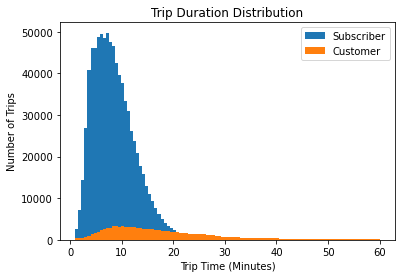

In [31]:
plt.hist(df8[(df8.duration_sec<=60) & (df8.subscriber_type == 'Subscriber')]['duration_sec'],bins=100)
plt.hist(df8[(df8.duration_sec<=60) & (df8.subscriber_type == 'Customer')]['duration_sec'],bins=100)

plt.title('Trip Duration Distribution')
plt.xlabel('Trip Time (Minutes)')
plt.ylabel('Number of Trips')
plt.legend(['Subscriber','Customer'])
pass

It is evident that subscriber trips occupy most of the trips dataset. Because of the massive discrepancy between customers and subscribers, we will plot the subscriber and customer distributions separately for further examination.

Average subscriber trip time (no outliers beyond 60 minutes):  8.79 minutes.
Average subscriber trip time (full dataset):  9.71 minutes.
Average customer trip time (no outliers beyond 60 minutes):  18.54 minutes.
Average customer trip time (full dataset):  61.98 minutes.




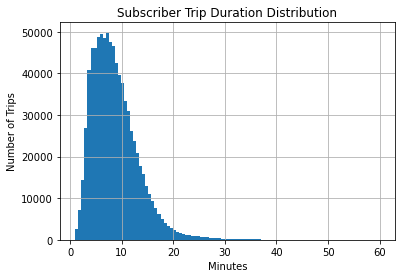

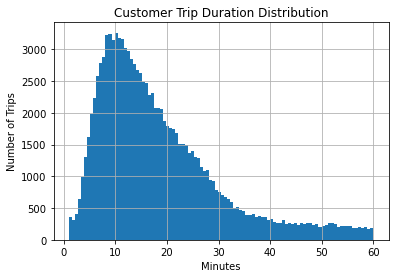

In [32]:
#distribution of triptimes by customer type
#get rid of outliers...trips longer than 60 minutes
subscriber_triptimes[subscriber_triptimes.duration_sec<=60].hist(column='duration_sec',bins=100)
plt.title('Subscriber Trip Duration Distribution')
plt.xlabel('Minutes')
plt.ylabel('Number of Trips')

customer_triptimes[customer_triptimes.duration_sec<=60].hist(column='duration_sec',bins=100)
plt.title('Customer Trip Duration Distribution')
plt.xlabel('Minutes')
plt.ylabel('Number of Trips')
pass

x = subscriber_triptimes[subscriber_triptimes.duration_sec<=60].drop(['trip_id','subscriber_type'],axis=1)
y = customer_triptimes[customer_triptimes.duration_sec<=60].drop(['trip_id','subscriber_type'],axis=1)

print("Average subscriber trip time (no outliers beyond 60 minutes): ", round((x['duration_sec'].mean()),2), "minutes.")
print("Average subscriber trip time (full dataset): ", round((subscriber_triptimes['duration_sec'].mean()),2), "minutes.")
print("Average customer trip time (no outliers beyond 60 minutes): ", round((y['duration_sec'].mean()),2), "minutes.")
print("Average customer trip time (full dataset): ", round((customer_triptimes['duration_sec'].mean()),2), "minutes.")
print('\n')

If we purge the dataset of trips that take longer than 60 minutes, the average customer trip takes nearly twice as long as the average subscriber trip. However, it turns out that the full dataset shows that the average customer trip actually takes over an hour long. We will re-visit these long customer trip times later in our analysis.

Now let's investigate on how ridership is distributed across days of the week. Leveraging timestamps that bikes log when trips begin, we can extract information pertaining to the month, year, and day that each trip took place.

In [15]:
#parse times from start_date...organize into days of the week
sql_query10 = """
SELECT EXTRACT(month from start_date AT TIME ZONE "UTC") AS MonthofTrip,
       EXTRACT(year from start_date AT TIME ZONE "UTC") AS YearofTrip,
       EXTRACT(day from start_date AT TIME ZONE "UTC") AS DayofTrip, 
       subscriber_type,
       count(trip_id) As NumTrips
FROM `bigquery-public-data.san_francisco.bikeshare_trips` bikeshare_trips
LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` bikeshare_trips_start
ON bikeshare_trips.start_station_id = bikeshare_trips_start.station_id
LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` bikeshare_trips_end
ON bikeshare_trips.end_station_id = bikeshare_trips_end.station_id 
GROUP BY 1,2,3,4
ORDER BY 2,1,3
"""
df10 = client.query(sql_query10).to_dataframe()

In [16]:
#parse year, day, month to create a new date column, as well as create new column to identify each day of the week
df10['Date'] = pd.to_datetime(df10.YearofTrip.astype(str) + '/' + df10.MonthofTrip.astype(str) + '/' + \
                              df10.DayofTrip.astype(str)).map(lambda x: x.strftime('%Y-%m-%d'))
df10['isWeekend'] = ((pd.to_datetime(df10['Date']).dt.dayofweek) // 5).astype(float)
df10['DayofWeek'] = ((pd.to_datetime(df10['Date']).dt.day_name()))

weekday_order = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

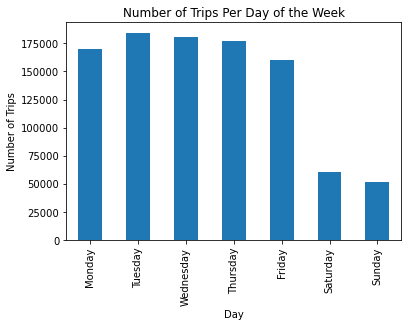

In [17]:
weekday_order = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df10.groupby(['DayofWeek']).sum().reindex(weekday_order)['NumTrips'].plot(kind='bar')
plt.title('Number of Trips Per Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Trips')
pass

Most of the rides are happening on the weekdays, with noticeably less ridership activity on weekends. 
Let's create a stacked column chart to differentiate between subscriber and customer rides over the course of a week.

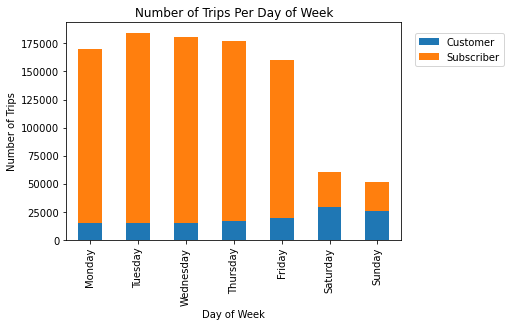

In [18]:
weekday_order = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df10.groupby(['DayofWeek','subscriber_type']).sum()['NumTrips'].unstack().reindex(weekday_order).plot(kind='bar', stacked=True)
plt.title('Number of Trips Per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.legend(loc=(1.04,0.8))
pass

From this bar chart, we can see that subscribers tend to ride bikes during weekdays, possibly indicating that they may be commuting to and from work. Furthermore, customer ridership increases over the weekend compared to the other days of the week.

Moving on with our analysis, we investigate the hourly activity of bike trips to see if commuters follow an hourly pattern. Since each bike trip in the bikeshare_trips dataset has a unique trip_id, we can aggregate them using BigQuery and group them by hour, which is extracted from the timestamps that bikes log when trips begin.

In [19]:
#Number of trips for every hour, based on time of trip start, customer vs subscriber

sql_query2 = """
SELECT EXTRACT(hour from start_date AT TIME ZONE "UTC") AS HourOfDay,
       subscriber_type,
       count(trip_id) As NumTrips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY 1,2
ORDER BY 1, NumTrips DESC;
"""

df2 = client.query(sql_query2).to_dataframe()

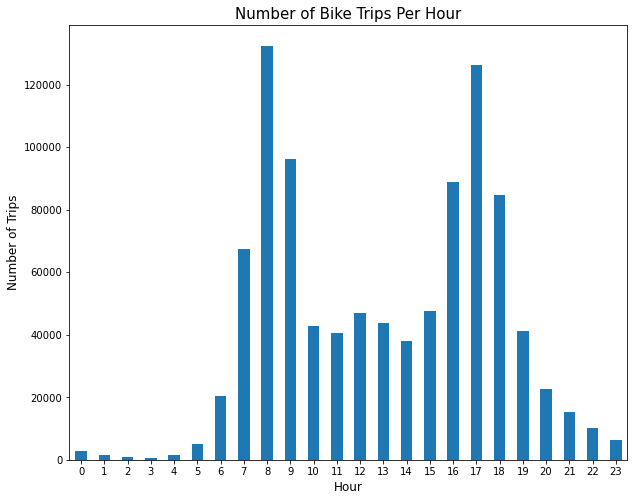

In [28]:
df2.groupby('HourOfDay').agg({'NumTrips':sum}).plot(kind='bar', figsize=(10,8))
plt.title('Number of Bike Trips Per Hour', fontdict={'fontsize':15})
plt.xlabel('Hour', fontdict={'fontsize':12})
plt.xticks(rotation='horizontal')
plt.ylabel('Number of Trips', fontdict={'fontsize':12})
plt.legend('', frameon=False)
pass

Ridership data reveals spikes in trip numbers during conventional rush hour times of 7am-9am in the mornings and 4pm-6pm in the evenings. Since the majority of the bikeshare_trips are from trips made by subscribers, we can begin to infer that commuters are subscribers. To confirm this, we will create another histogram that differentiates ridership between customers and subscribers.


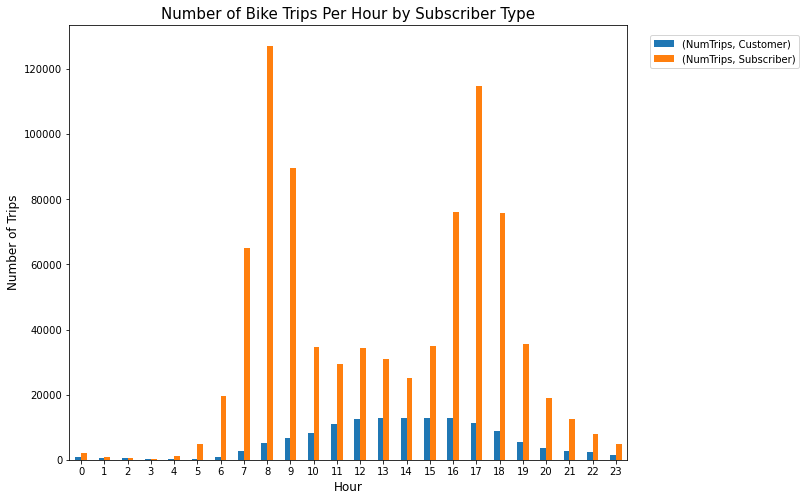

In [29]:
df2.pivot(index = 'HourOfDay',columns='subscriber_type').plot(kind='bar', figsize=(10,8))
                                                              
plt.title('Number of Bike Trips Per Hour by Subscriber Type', fontdict={'fontsize':15})
plt.xlabel('Hour',fontdict={'fontsize':12})
plt.xticks(rotation='horizontal')
plt.ylabel('Number of Trips',fontdict={'fontsize':12})
plt.legend(loc=(1.04,0.9))
pass

The histogram above confirms that subscribers adhere to rush hour times and customers do not. Contrary to the bimodal distribution that subscriber ridership observes, customer ridership illustrates a seemingly normal distribution, with peak ridership in the afternoon from 12pm-4pm.

The bikeshare_stations dataset has a column labeled as landmark, which designates five cities in the Bay Area that various bike stations are located in: San Francisco, San Jose, Mountain View, Redwood City, and Palo Alto. We can use this data to see where riders are traveling from and see if the rush hour patterns hold.


In [31]:
#Number of trips for every hour according to landmark

sql_query3 = """
SELECT EXTRACT(hour from start_date AT TIME ZONE "UTC") AS HourOfDay,
       landmark,
       subscriber_type,
       count(trip_id) As NumTrips
FROM `bigquery-public-data.san_francisco.bikeshare_trips` trips
LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` stations
ON trips.start_station_id = stations.station_id
GROUP BY 1,2,3
ORDER BY 1, NumTrips DESC;
"""

df3 = client.query(sql_query3).to_dataframe()

In [32]:
#the majority of trips occurred in San Francisco
landmark_trips = df3.groupby('landmark').agg({'NumTrips':sum})
landmark_trips.reset_index()


,landmark,NumTrips
0,Mountain View,24679
1,Palo Alto,9889
2,Redwood City,4996
3,San Francisco,891223
4,San Jose,52861


From the table above, most trips take place in San Francisco. Now, we can differentiate ridership by subscriber_type when observing the number of trips per hour for each of these cities.

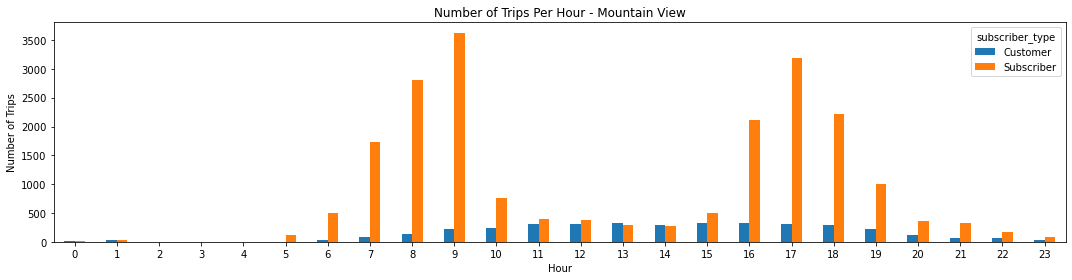

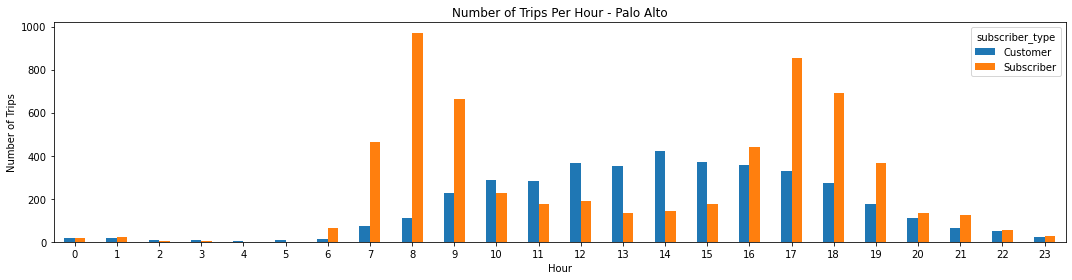

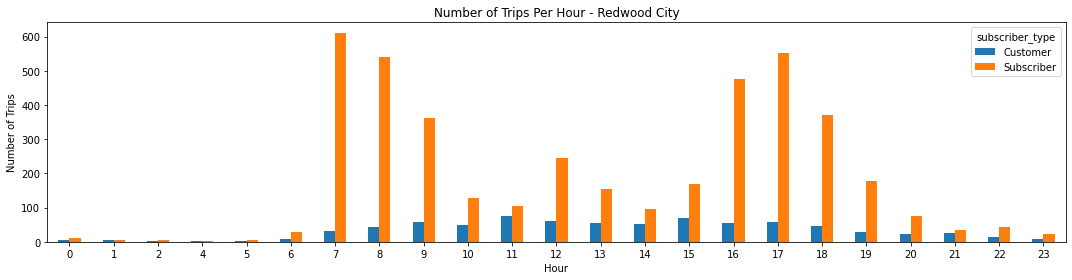

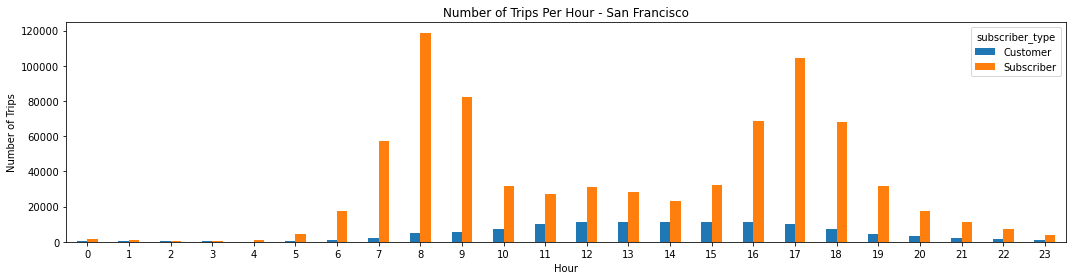

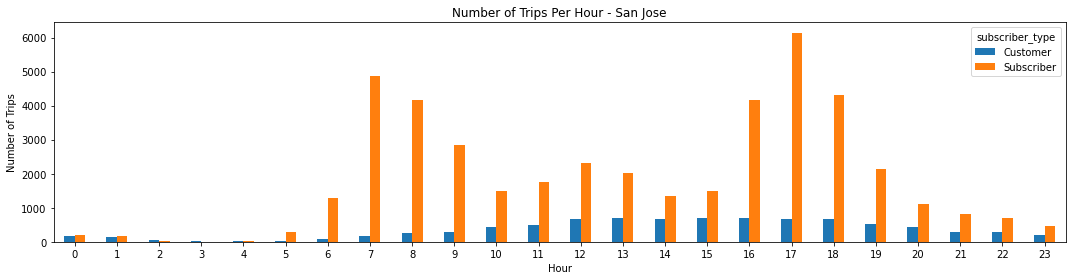

In [34]:
df3[df3.landmark == 'Mountain View'].pivot(index='HourOfDay',columns='subscriber_type')['NumTrips'].plot(kind='bar', figsize=(15,4))
plt.title('Number of Trips Per Hour - Mountain View')
plt.xlabel('Hour')
plt.xticks(rotation='horizontal')
plt.ylabel('Number of Trips')
plt.tight_layout()

df3[df3.landmark == 'Palo Alto'].pivot(index='HourOfDay',columns='subscriber_type')['NumTrips'].plot(kind='bar', figsize=(15,4))
plt.title('Number of Trips Per Hour - Palo Alto')
plt.xlabel('Hour')
plt.xticks(rotation='horizontal')
plt.ylabel('Number of Trips')
plt.tight_layout()

df3[df3.landmark == 'Redwood City'].pivot(index='HourOfDay',columns='subscriber_type')['NumTrips'].plot(kind='bar', figsize=(15,4))
plt.title('Number of Trips Per Hour - Redwood City')
plt.xlabel('Hour')
plt.xticks(rotation='horizontal')
plt.ylabel('Number of Trips')
plt.tight_layout()

df3[df3.landmark == 'San Francisco'].pivot(index='HourOfDay',columns='subscriber_type')['NumTrips'].plot(kind='bar', figsize=(15,4))
plt.title('Number of Trips Per Hour - San Francisco')
plt.xlabel('Hour')
plt.xticks(rotation='horizontal')
plt.ylabel('Number of Trips')
plt.tight_layout()

df3[df3.landmark == 'San Jose'].pivot(index='HourOfDay',columns='subscriber_type')['NumTrips'].plot(kind='bar', figsize=(15,4))
plt.title('Number of Trips Per Hour - San Jose')
plt.xlabel('Hour')
plt.xticks(rotation='horizontal')
plt.ylabel('Number of Trips')
plt.tight_layout()

pass

We can see that rush hour activity for subscribers are consistent across all landmarks in the Bay Area, with spikes of activity from 7am-9am and 4pm-6pm. Thus, we can assume that commuters are subscribers.

In order to identify the most popular trips for commuters, we operate on the following assumptions:
- Commuter trips occur on the weekdays
- Commuter trips occur during peak rush hour times during 7am-9am and 4pm-6pm
- Commuter trips would start from one station and end at a different station (one-way trip)
- Subscribers are likely to be commuters

In [4]:
#identifying commuter trips: one-way trips in AM, subscriber, Mon-Fri

sql_query5 = """
SELECT EXTRACT(hour from start_date AT TIME ZONE "UTC") AS HourOfDay, 
       start_station_name,
       end_station_name,
       count(trip_id) AS NumTrips,
       round(avg(duration_sec)/60,2) As AvgTripDuration
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE subscriber_type = "Subscriber" AND
      start_station_name != end_station_name AND
      CAST(EXTRACT(DAYOFWEEK FROM start_date) AS STRING) IN ('2','3','4','5','6')
GROUP BY 1,2,3
ORDER BY 1,4 DESC;
"""

df5 = client.query(sql_query5).to_dataframe()

In [10]:
print('Top 5 Commuter Trips: ')
df5[df5['HourOfDay'].isin([7,8,9,16,17,18])].groupby(['start_station_name','end_station_name'])\
                    .agg({'NumTrips':sum,'AvgTripDuration':'mean'}).reset_index().sort_values('NumTrips', ascending=False).head(5)

Top 5 Commuter Trips: 


,start_station_name,end_station_name,NumTrips,AvgTripDuration
88,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5034,8.605000
684,Harry Bridges Plaza (Ferry Building),2nd at Townsend,4973,10.195000
1314,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4958,4.375000
559,Embarcadero at Sansome,Steuart at Market,4689,6.725000
518,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4686,10.163333


In [11]:
print('Top 5 Commuter Trips (7am-9am): ')
df5[df5['HourOfDay'].isin([7,8,9])].groupby(['start_station_name','end_station_name'])\
                    .agg({'NumTrips':sum,'AvgTripDuration':'mean'}).reset_index().sort_values('NumTrips', ascending=False).head(5)

Top 5 Commuter Trips (7am-9am): 


,start_station_name,end_station_name,NumTrips,AvgTripDuration
629,Harry Bridges Plaza (Ferry Building),2nd at Townsend,4452,10.020000
1425,Steuart at Market,2nd at Townsend,3716,8.533333
1205,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,3461,4.490000
1147,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,3341,10.456667
1167,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),3088,11.413333


In [12]:
print('Top 5 Commuter Trips (4pm-6pm): ')
df5[df5['HourOfDay'].isin([16,17,18])].groupby(['start_station_name','end_station_name'])\
                    .agg({'NumTrips':sum,'AvgTripDuration':'mean'}).reset_index().sort_values('NumTrips', ascending=False).head(5)

Top 5 Commuter Trips (4pm-6pm): 


,start_station_name,end_station_name,NumTrips,AvgTripDuration
88,2nd at Townsend,Harry Bridges Plaza (Ferry Building),4077,8.093333
500,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),3967,10.463333
541,Embarcadero at Sansome,Steuart at Market,3700,6.610000
1545,Steuart at Market,San Francisco Caltrain (Townsend at 4th),3322,12.443333
1581,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),3275,11.106667


We can see that the start and endpoints of the most popular commuter trips are located near other hubs of transportation like the San Francisco Caltrain, the Ferry, the Transbay Terminal, and the pier. 

- Ferry:
    * Harry Bridges Plaza
    * Steuart at Market
- Pier:
    * Embarcadero at Sansome
- San Francisco Caltrain
    * 2nd at Townsend
    * 330 Townsend
    * Townsend at 4th
    * Townsend at 7th
- Light Rail
    * Embarcadero at Folsom
- Bus
    * Temporary Transbay Terminal (Howard at Beale)

This suggests that bikesharing is only part of the overall trip of the typical San Francisco commuter.
Bay Wheels should consider partnering with some of the other transportation services to promote bike ridership. An example would be to offer a special package deal with the Ferry or Caltrain that offers Bay Wheels' annual membership perks at a competitive rate.

## __Other Analyses - Improving Bay Wheels__
#### Project Question 2: What are your recommendations for offers (justify based on your findings)?

This section focuses on analysis that seeks to improve the bikeshare service. 
So far, we know that ridership decreases on weekends and that customers tend to ride more on weekends. 
Let's examine the condition of bike stations.

### Dock Availability

Let's investigate the reliability of the bikeshare service. This section will identify the levels of bike availability during rush hour times. Popular bike stations with low bike availability during busy hours would inconvenience riders since they would be unable to attain bikes during their commute. We should also consider the converse - when stations are at high or full capacity during rush hours. In these situations, it would be more difficult for commuters to find available docking stations near their end-trip destinations. This would also disrupt people's commute if they have to bike to another station just to dock it and avoid paying penalty fees. 

We are only concerned with bike stations that have high volumes of trips either starting from them or ending at them. These stations are not only the most popular, but would also have the highest number of ingress and egress bikes. Thus, we assume that the high frequency of bikes coming in and out would have an effect on the availability of docks and bikes available at these stations. We begin by querying each station's total number of start and end trips (as separate queries). Then, we merge the queries together into a single dataframe.

In [68]:
#find the most busy bike stations

sql_query11 = """
SELECT start_station_name,
       subscriber_type,
       count(trip_id) AS NumTrips_Start
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
GROUP BY 1,2
ORDER BY 2 DESC;
"""

sql_query12 = """
SELECT end_station_name,
       subscriber_type,
       count(trip_id) AS NumTrips_End
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
GROUP BY 1,2
ORDER BY 2 DESC;
"""

df11 = client.query(sql_query11).to_dataframe()
df12 = client.query(sql_query12).to_dataframe()

We have identified 38 out of 84 bike stations that have greater than 10,000 total bike trips in the dataset.

In [70]:
df11_gp = df11.groupby('start_station_name').agg({'NumTrips_Start':sum}).reset_index().sort_values(by='NumTrips_Start',ascending=False)
df12_gp = df12.groupby('end_station_name').agg({'NumTrips_End':sum}).reset_index().sort_values(by='NumTrips_End',ascending=False)

df_hotspots = pd.merge(df11_gp,df12_gp,left_on='start_station_name', right_on='end_station_name')\
                .drop('end_station_name',axis=1).set_index('start_station_name')[:38]

print('Top 5 Station Hotspots: ')
df_hotspots.head()

Top 5 Station Hotspots: 


,NumTrips_Start,NumTrips_End
start_station_name,,
San Francisco Caltrain (Townsend at 4th),72683,92014
San Francisco Caltrain 2 (330 Townsend),56100,58713
Harry Bridges Plaza (Ferry Building),49062,50185
Embarcadero at Sansome,41137,46197
2nd at Townsend,39936,44145


Now that we have identified our bike station hotspots, we can examine their average hourly bike availability during rush hour times (7am-9am and 4pm-6pm on weekdays). The bikeshare_status dataset shows the number of bikes and docks available for each station at various points in time. Since this dataset has over 100,000,000 rows, we take the liberty of averaging each docking station's number of bikes and docks available in any given hour per day of the week.

In [72]:
#status of bike stations throughout the day by hour
sql_query7 = """
SELECT EXTRACT(hour from status.time AT TIME ZONE "UTC") AS HourOfDay,
       EXTRACT(DAYOFWEEK from status.time at TIME ZONE "UTC") AS DayOfWeek,
       stations.station_id,
       stations.name,
       stations.dockcount,
       AVG(bikes_available) AS AvgBikesAvail,
       AVG(docks_available) AS AvgDocksAvail
FROM `bigquery-public-data.san_francisco.bikeshare_status` status
JOIN `bigquery-public-data.san_francisco.bikeshare_stations` stations
ON status.station_id = stations.station_id
GROUP BY 1,2,3,4,5
ORDER BY 1,2;
"""
df7 = client.query(sql_query7).to_dataframe()

In [277]:
df7[(df7['HourOfDay'].isin([7,8,9,16,17,18])) & \
    (df7['DayOfWeek'].isin([2,3,4,5,6])) & \
    (df7['name'].isin(df_hotspots.reset_index()['start_station_name']) == True)]\
    .sort_values('AvgBikesAvail').head(10)

,HourOfDay,DayOfWeek,station_id,name,dockcount,AvgBikesAvail,AvgDocksAvail
9691,18,5,82,Broadway St at Battery St,15,2.777243,12.180180
9543,18,3,82,Broadway St at Battery St,15,2.935971,11.907514
9617,18,4,82,Broadway St at Battery St,15,3.015096,11.896416
9437,18,2,45,Commercial at Montgomery,15,3.057195,11.900043
4872,9,3,70,San Francisco Caltrain (Townsend at 4th),19,3.080692,15.802055
9514,18,3,48,Embarcadero at Vallejo,15,3.116083,11.834090
9469,18,2,82,Broadway St at Battery St,15,3.230826,11.710111
9440,18,2,48,Embarcadero at Vallejo,15,3.422172,11.495189
3816,7,3,48,Embarcadero at Vallejo,15,3.453742,11.543239
4946,9,4,70,San Francisco Caltrain (Townsend at 4th),19,3.459396,15.464343


At first impression, it appears that the station at Broadway St at Battery St tends to have low bike availability during 6pm on the weekdays.

Since the dataframe above has over 1000 rows, let's narrow our window of analysis. 
The average bike station has 18 total docks, so we will arbitrarily look at stations with hourly average bike availability of less than 4. In other words, stations in our scope would, on average, have less than 22% of total bikes left available.

In [92]:
view1 = df7[(df7['HourOfDay'].isin([7,8,9,16,17,18])) & \
        (df7['DayOfWeek'].isin([2,3,4,5,6])) & \
        (df7['name'].isin(df_hotspots.reset_index()['start_station_name']) == True) & \
        (df7['AvgBikesAvail'] <= 4)]\
        .groupby(['name','dockcount']).agg({'station_id':'count'}).sort_values('station_id', ascending=False)

view2 = df7[(df7['HourOfDay'].isin([7,8,9,16,17,18])) & \
        (df7['DayOfWeek'].isin([2,3,4,5,6])) & \
        (df7['name'].isin(df_hotspots.reset_index()['start_station_name']) == True) & \
        (df7['AvgBikesAvail'] <= 4)]\
        .groupby(['name','dockcount']).agg({'AvgBikesAvail': 'mean'}).sort_values('AvgBikesAvail', ascending=True)

view3 = pd.merge(view1, view2, on=['name','dockcount']).rename(columns = {'station_id':'NumOccurrences'})

pd.merge(view3.reset_index(), df_hotspots.reset_index(), left_on='name', right_on='start_station_name').drop('start_station_name',axis=1)

,name,dockcount,NumOccurrences,AvgBikesAvail,NumTrips_Start,NumTrips_End
0,Embarcadero at Vallejo,15,7,3.545890,15302,17620
1,Broadway St at Battery St,15,5,3.164464,16005,14095
2,Commercial at Montgomery,15,5,3.571649,16857,16393
3,San Francisco Caltrain (Townsend at 4th),19,5,3.545740,72683,92014
4,Embarcadero at Bryant,15,1,3.835646,22525,19454
5,Embarcadero at Sansome,15,1,3.898102,41137,46197
6,Santa Clara at Almaden,11,1,3.942931,5308,5158


In the dataframe above, the column 'NumOccurrences' shows the number of times a station's bike availability reached below 4. We included columns for the total number of start and end trips for each station as well to show how generally busy these stations are relative to each other.

We have identified some busy bike stations with a tendency for low capacity during rush hours:
- San Francisco Caltrain (Townsend at 4th)
- Embarcadero at Vallejo
- Commercial at Montgomery
- Broadway St at Battery St

Bay Wheels should consider expanding the dock count for these stations as they see higher levels of demand during peak hours. Alternatively, the company could also employ services that allocate bikes from less popular stations to the stations mentioned above during peak hours.

For reference, the dataframe below shows during which days of the week and hours that stations reached an average hourly bike availability below the threshold of 4.

In [293]:
df7[(df7['HourOfDay'].isin([7,8,9,16,17,18])) & \
    (df7['DayOfWeek'].isin([2,3,4,5,6])) & \
    (df7['name'].isin(df_hotspots.reset_index()['start_station_name']) == True) & \
    (df7['AvgBikesAvail'] <= 4)]\
    .sort_values(by=['DayOfWeek','HourOfDay','AvgBikesAvail','name'], ascending=[True,True,True,True])

,HourOfDay,DayOfWeek,station_id,name,dockcount,AvgBikesAvail,AvgDocksAvail
4798,9,2,70,San Francisco Caltrain (Townsend at 4th),19,3.466495,15.379155
4782,9,2,54,Embarcadero at Bryant,15,3.835646,11.098634
9437,18,2,45,Commercial at Montgomery,15,3.057195,11.900043
9469,18,2,82,Broadway St at Battery St,15,3.230826,11.710111
9440,18,2,48,Embarcadero at Vallejo,15,3.422172,11.495189
3816,7,3,48,Embarcadero at Vallejo,15,3.453742,11.543239
3826,7,3,60,Embarcadero at Sansome,15,3.898102,11.054669
4872,9,3,70,San Francisco Caltrain (Townsend at 4th),19,3.080692,15.802055
9543,18,3,82,Broadway St at Battery St,15,2.935971,11.907514
9514,18,3,48,Embarcadero at Vallejo,15,3.116083,11.834090


We can repeat the same exercise, but in the context of stations having __*too many*__ bikes available so that it could impede riders from ingress. The following dataframe shows that Harry Bridges Plaza has an hourly average dock availability of 5 and below during 6pm on certain weekdays.

In [297]:
df7[(df7['HourOfDay'].isin([7,8,9,16,17,18])) & \
    (df7['DayOfWeek'].isin([2,3,4,5,6])) & \
    (df7['name'].isin(df_hotspots.reset_index()['start_station_name']) == True)]\
    .sort_values('AvgBikesAvail',ascending=False).head(30)

,HourOfDay,DayOfWeek,station_id,name,dockcount,AvgBikesAvail,AvgDocksAvail
9442,18,2,50,Harry Bridges Plaza (Ferry Building),23,18.616100,4.240539
9590,18,4,50,Harry Bridges Plaza (Ferry Building),23,18.126126,4.675676
9516,18,3,50,Harry Bridges Plaza (Ferry Building),23,17.831064,4.958387
9664,18,5,50,Harry Bridges Plaza (Ferry Building),23,17.418157,5.352639
4057,7,6,69,San Francisco Caltrain 2 (330 Townsend),23,16.688942,6.283897
3761,7,2,69,San Francisco Caltrain 2 (330 Townsend),23,16.668141,6.269737
3909,7,4,69,San Francisco Caltrain 2 (330 Townsend),23,16.652141,6.161518
3983,7,5,69,San Francisco Caltrain 2 (330 Townsend),23,16.402039,6.519961
9738,18,6,50,Harry Bridges Plaza (Ferry Building),23,16.133012,6.666881
8924,17,2,50,Harry Bridges Plaza (Ferry Building),23,16.088679,6.773482


In [93]:
view4 = df7[(df7['HourOfDay'].isin([7,8,9,16,17,18])) & \
        (df7['DayOfWeek'].isin([2,3,4,5,6])) & \
        (df7['name'].isin(df_hotspots.reset_index()['start_station_name']) == True) & \
        (df7['AvgBikesAvail']/df7['dockcount'] >= 0.78)]\
        .groupby(['name','dockcount']).agg({'station_id':'count'}).sort_values('station_id', ascending=False)
view4

view5 = df7[(df7['HourOfDay'].isin([7,8,9,16,17,18])) & \
        (df7['DayOfWeek'].isin([2,3,4,5,6])) & \
        (df7['name'].isin(df_hotspots.reset_index()['start_station_name']) == True) & \
        (df7['AvgBikesAvail']/df7['dockcount'] >= 0.78)]\
        .groupby(['name','dockcount']).agg({'AvgBikesAvail': 'mean'}).sort_values('AvgBikesAvail', ascending=True)
view5

view6 = pd.merge(view4, view5, on=['name','dockcount']).rename(columns = {'station_id':'NumOccurrences'})

pd.merge(view6.reset_index(), df_hotspots.reset_index(), left_on='name', right_on='start_station_name').drop('start_station_name',axis=1)

,name,dockcount,NumOccurrences,AvgBikesAvail,NumTrips_Start,NumTrips_End
0,Harry Bridges Plaza (Ferry Building),23,2,18.371113,49062,50185


The dataframe above shows that Harry Bridges Plaza (Ferry Building) reached a dock availability capacity below 22% twice.

Since the station at Harry Bridges Plaza (Ferry Building) is one of Bay Wheels' most popular bike stations, in order to account for the low hourly average bike capacity at 6pm on weeknights, Bay Wheels should also consider expanding docks at this station.
However, as we can see from the number of occurrences of bike availability above and below our thresholds, stations having low bike availability is a more common problem than stations having too many bikes (or low dock availability).

### Subscribers vs. Customers

We have already examined the differences between average trip time, the days in which most trips take place, and the hourly activity between subscribers and customers.
We also noticed that the number of subscriber trips are much greater than that of customer trips. Thus, this section will investigate ways in which Bay Wheels can improve customer ridership.

First, let's perform a deeper dive into customer ridership activity. We begin by querying for every trip combination (start and end destinations), the number of occurrences of such trips, the average duration for these trips, as well as the days and hours in which they occur.

In [16]:
sql_query14 = """
SELECT EXTRACT(hour from start_date AT TIME ZONE "UTC") AS HourOfDay, 
       EXTRACT(DAYOFWEEK FROM start_date) As DayofWeek,
       start_station_name,
       end_station_name,
       count(trip_id) AS NumTrips,
       round(avg(duration_sec)/60,2) As AvgTripDuration
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE subscriber_type = "Customer"
GROUP BY 1,2,3,4
ORDER BY 1,5 DESC;
"""

df14 = client.query(sql_query14).to_dataframe()

From here, we can see the top 5 most popular customer trips, the most common customer trip at every hour, and the most popular trips for customers on weekends (which is when customer ridership increases).

In [19]:
print('Top 5 Customer Trips: ')
df14.groupby(['start_station_name','end_station_name'])\
    .agg({'NumTrips':sum, 'AvgTripDuration':'mean'})\
    .reset_index().sort_values('NumTrips', ascending=False)\
    .head(5)

Top 5 Customer Trips: 


,start_station_name,end_station_name,NumTrips,AvgTripDuration
763,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,3667,32.098425
592,Embarcadero at Sansome,Embarcadero at Sansome,2545,71.900543
767,Harry Bridges Plaza (Ferry Building),Harry Bridges Plaza (Ferry Building),2004,98.664891
596,Embarcadero at Sansome,Harry Bridges Plaza (Ferry Building),1638,28.931157
630,Embarcadero at Vallejo,Embarcadero at Sansome,1345,59.510091


In [58]:
print('The Most Common Customer Trip per Hour: \n')
df14.groupby(['HourOfDay','start_station_name','end_station_name'])\
    .agg({'NumTrips':sum,'AvgTripDuration':'mean'})\
    .sort_values(by=['HourOfDay','NumTrips'], ascending=[True,False]).reset_index().groupby('HourOfDay').head(1)

The Most Common Customer Trip per Hour: 



,HourOfDay,start_station_name,end_station_name,NumTrips,AvgTripDuration
0,0,Embarcadero at Sansome,Embarcadero at Sansome,20,46.266000
384,1,Grant Avenue at Columbus Avenue,Grant Avenue at Columbus Avenue,17,128.346000
698,2,Embarcadero at Bryant,San Francisco Caltrain (Townsend at 4th),9,11.746667
895,3,Embarcadero at Sansome,5th at Howard,7,21.550000
1024,4,Powell Street BART,Powell Street BART,7,69.197500
1129,5,Powell at Post (Union Square),Powell at Post (Union Square),11,100.322000
1310,6,Powell at Post (Union Square),Powell at Post (Union Square),49,94.525714
1730,7,Harry Bridges Plaza (Ferry Building),Harry Bridges Plaza (Ferry Building),48,85.020000
2534,8,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,118,27.607143
3643,9,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,163,40.437143


In [21]:
print('Top 5 Most Common Customer Trips Over Weekends\n')
df14[df14['DayofWeek'].isin([1,7])]\
    .groupby(['start_station_name','end_station_name'])\
    .agg({'NumTrips':sum, 'AvgTripDuration':'mean'})\
    .reset_index()\
    .sort_values(by='NumTrips', ascending=False).head(5)

Top 5 Most Common Customer Trips Over Weekends



,start_station_name,end_station_name,NumTrips,AvgTripDuration
711,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,1669,34.088378
549,Embarcadero at Sansome,Embarcadero at Sansome,1076,72.592308
715,Harry Bridges Plaza (Ferry Building),Harry Bridges Plaza (Ferry Building),1010,88.508864
553,Embarcadero at Sansome,Harry Bridges Plaza (Ferry Building),743,27.983143
1740,University and Emerson,University and Emerson,582,122.533333


From our dataframes pertaining to customer ridership, we can see that there are many trips - both one-way and roundtrip - between Harry Bridges Plaza and Embarcadero at Sansome. Furthermore, average trip times are noticeably much longer for customers compared to subscribers. According to Bay Wheels' pricing policy, bikes that are taken out longer than 30 minutes at a time will incur additional costs of \\$3 per additional 15 minutes. From the dataframe above showing the five most common customer trips on weekends, we can see that many trips exceed the 30-minute threshold. Thus, these weekend trips that customers enjoy can become expensive and potentially deter them from using the bikeshare service in the future.

Bay Wheels offers the Access Pass for unlimited 30-minute trips in a day, which is cost-effective for customers who take long trips. However, the pass still requires bikes to be checked at a dock station every 30 minutes. In order to improve customer satisfaction and prevent frustrating them with additional fees, Bay Wheels should improve the user experience of its mobile application. Before starting a trip, users should be able to plan routes and find nearby docks near their current and end destinations. The application should also provide easy-to-read information about the time elapsed in the trip and recommend nearby check-in stations with available docks (as discussed before about ensuring stations have bikes and docks available for ingress and egress). This intuitive experience would help customers to better enjoy their trips and have them worry less about inconveniences and surcharges.

Moving on with our analysis of the differences between subscribers and customers, let's compare the stations that they most frequent respectively. We begin by querying the bikeshare_trips dataset for every trip's start and end destinations and aggregating the number of trips between each destination. Then, we graph the top 10 most busy bike stations based on the number of trips that started from and ended at each of them.

In [44]:
#find the most busy bike stations

sql_query11 = """
SELECT start_station_name,
       subscriber_type,
       count(trip_id) AS NumTrips_Start
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
GROUP BY 1,2
ORDER BY 2 DESC;
"""

sql_query12 = """
SELECT end_station_name,
       subscriber_type,
       count(trip_id) AS NumTrips_End
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
GROUP BY 1,2
ORDER BY 2 DESC;
"""

df11 = client.query(sql_query11).to_dataframe()
df12 = client.query(sql_query12).to_dataframe()

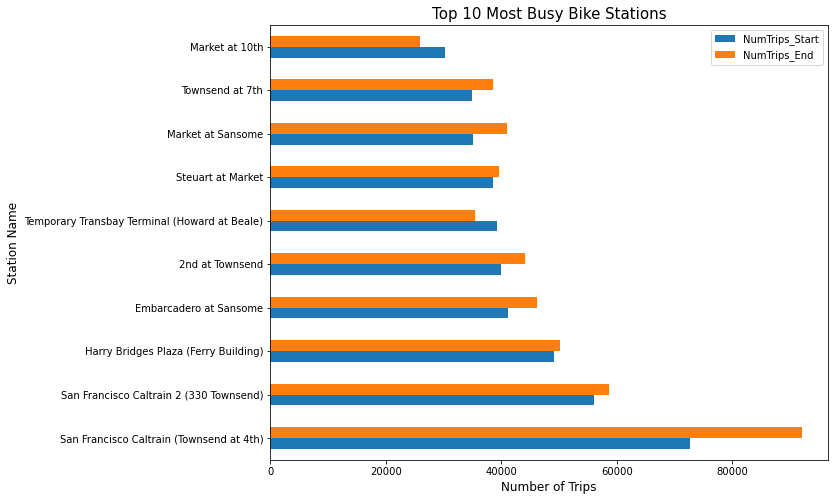

In [45]:
df11_gp = df11.groupby('start_station_name').agg({'NumTrips_Start':sum}).reset_index().sort_values(by='NumTrips_Start',ascending=False)
df12_gp = df12.groupby('end_station_name').agg({'NumTrips_End':sum}).reset_index().sort_values(by='NumTrips_End',ascending=False)

pd.merge(df11_gp,df12_gp,\
         left_on='start_station_name', right_on='end_station_name')\
         .drop('end_station_name',axis=1).set_index('start_station_name')[:10].plot(kind='barh', figsize=(10,8))
plt.title('Top 10 Most Busy Bike Stations',fontdict={'fontsize':15})
plt.xlabel('Number of Trips',fontdict={'fontsize':12})
plt.ylabel('Station Name',fontdict={'fontsize':12})
pass

It's interesting to see that the most busy bike stations have more trips ending at them compared to starting from them. This provides further evidence that these stations are primary commuting hotspots since commuters would start from a variety of start stations and congregate towards these popular stations. We have already seen from previous analysis that commuter trips are revolved around other hubs of transportation.

Now, let's take a look into the most busy bike stations for subscribers and see how ridership breaks down between the two subscriber types. 

In [47]:
df11_pv_subscriber = df11.pivot(index='start_station_name',columns='subscriber_type')\
              .sort_values([('NumTrips_Start','Subscriber')],ascending=False).reset_index()
df12_pv_subscriber = df12.pivot(index='end_station_name',columns='subscriber_type')\
              .sort_values([('NumTrips_End','Subscriber')],ascending=False).reset_index()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


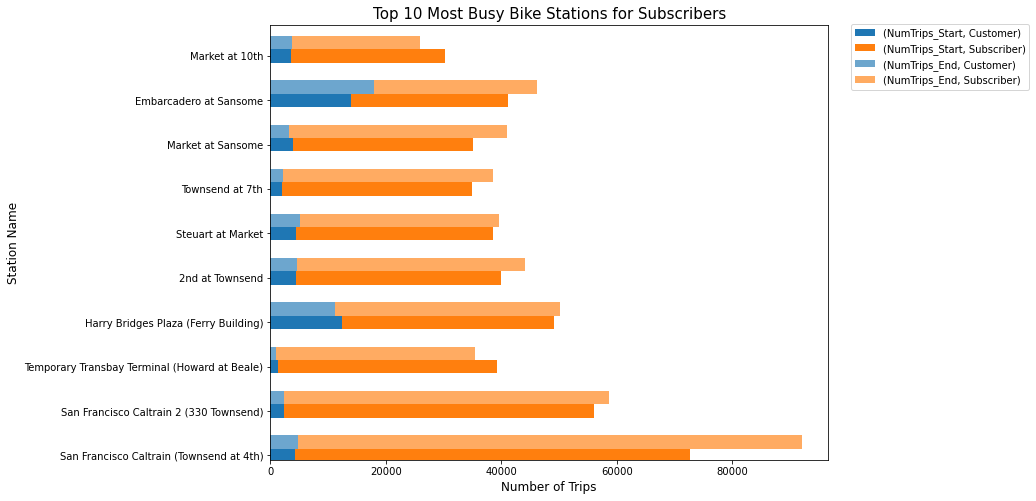

In [48]:
df_pv_subscriber_plot = pd.merge(df11_pv_subscriber, df12_pv_subscriber, left_on = 'start_station_name',\
                                 right_on = 'end_station_name').drop('end_station_name',axis=1)\
                                .set_index('start_station_name')[:10]

fig, ax = plt.subplots()
fig.set_size_inches(10,8)
df_pv_subscriber_plot[[('NumTrips_Start','Customer'),('NumTrips_Start','Subscriber')]].\
                        plot(kind='barh', stacked=True, width=0.3, position=0.5, ax=ax)
df_pv_subscriber_plot[[('NumTrips_End','Customer'),('NumTrips_End','Subscriber')]].\
                        plot(kind='barh', stacked=True, width=0.3, position=-0.5, alpha=0.65, ax=ax)
plt.title('Top 10 Most Busy Bike Stations for Subscribers',fontdict={'fontsize':15})
plt.xlabel('Number of Trips',fontdict={'fontsize':12}) 
plt.ylabel('Station Name', fontdict={'fontsize':12})
plt.legend(loc=(1.04,0.85))
pass

As suspected, the top 10 stations for subscribers match the top 10 stations for subscribers/customers in general. The large proportion of subscribers in the dataset skewed the general stations chart to reflect mostly subscriber behavior. Let's see the top 10 most popular stations for customers.

In [50]:
df11_pv_customer = df11.pivot(index='start_station_name',columns='subscriber_type')\
              .sort_values([('NumTrips_Start','Customer')],ascending=False).reset_index()
df12_pv_customer = df12.pivot(index='end_station_name',columns='subscriber_type')\
              .sort_values([('NumTrips_End','Customer')],ascending=False).reset_index()

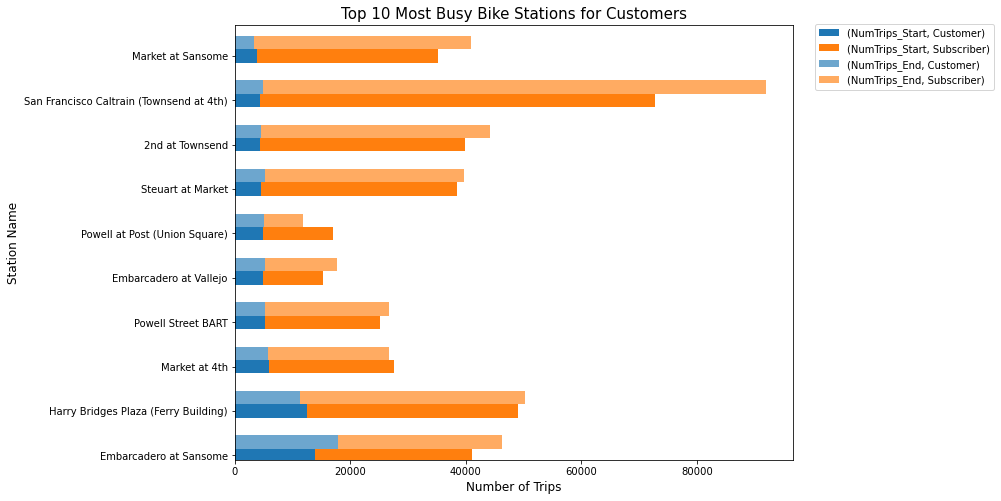

In [51]:
df_pv_customer_plot = pd.merge(df11_pv_customer, df12_pv_customer, left_on = 'start_station_name',\
                                 right_on = 'end_station_name').drop('end_station_name',axis=1)\
                                .set_index('start_station_name')[:10]

fig, ax = plt.subplots()
fig.set_size_inches(10,8)
df_pv_customer_plot[[('NumTrips_Start','Customer'),('NumTrips_Start','Subscriber')]].\
                        plot(kind='barh', stacked=True, width=0.3, position=0.5, ax=ax)
df_pv_customer_plot[[('NumTrips_End','Customer'),('NumTrips_End','Subscriber')]].\
                        plot(kind='barh', stacked=True, width=0.3, position=-0.5, alpha=0.65, ax=ax)
plt.title('Top 10 Most Busy Bike Stations for Customers', fontdict={'fontsize':15})
plt.xlabel('Number of Trips', fontdict={'fontsize':12}) 
plt.ylabel('Station Name', fontdict={'fontsize':12})
plt.legend(loc=(1.04,0.85))
pass

Out of the top 10 most popular stations for customers, six stations are located along or near the piers along The Embarcadero and King Street: 
- Embarcadero at Sansome
- Harry Bridges Plaza 
- Embarcadero at Vallejo 
- Steuart at Market
- 2nd at Townsend
- San Francisco Caltrain (Townsend at 4th)

Furthermore, the levels of start trips are generally greater than the levels of end trips at these locations. Taking into account of customer's long average trip times, our analysis suggests that customers are beginning their trips and enjoying leisurely and tourist activities by the water. Bay Wheels should look into expanding the number of bike stations along the piers and waters. For example, the neighborhood around Fisherman's Wharf - a busy tourist area - does not have any bike stations in its neighorhood. Installing bike stations in Fisherman's Wharf would encourage bike riders (subscribers and customers) to explore the area. The company can also partner with local vendors and businesses such as In-N-Out Burger and Ghirardelli Square for discounts and promotions exclusive to bike riders. Promoting a whole new area of service would boost overall levels of ridership.

### Monthly Activity

From the previous analysis, we have a general idea of __where__ we can boost customer ridership levels. Now, we turn our attention to __when__ we can boost customer ridership. We begin with an overall look into ridership levels for every month and year captured in the bikeshare_trips dataset.

In [35]:
sql_query6 = """
SELECT EXTRACT(month from start_date AT TIME ZONE "UTC") AS MonthofTrip,
       EXTRACT(year from start_date AT TIME ZONE "UTC") AS YearofTrip,
       bikeshare_trips_start.station_id,
       subscriber_type,
       bikeshare_trips_start.name,         
       count(trip_id) As NumTrips,
       row_number() OVER (PARTITION BY 1 order by 4 DESC) AS Rank
FROM `bigquery-public-data.san_francisco.bikeshare_trips` bikeshare_trips
LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` bikeshare_trips_start
ON bikeshare_trips.start_station_id = bikeshare_trips_start.station_id
LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` bikeshare_trips_end
ON bikeshare_trips.end_station_id = bikeshare_trips_end.station_id 
GROUP BY 1,2,3,4,5
ORDER BY 2,1, NumTrips DESC
"""

df6 = client.query(sql_query6).to_dataframe()
df6['Date'] = pd.to_datetime(df6.YearofTrip.astype(str) + '/' + df6.MonthofTrip.astype(str) + '/01').map(lambda x: x.strftime('%Y-%m'))


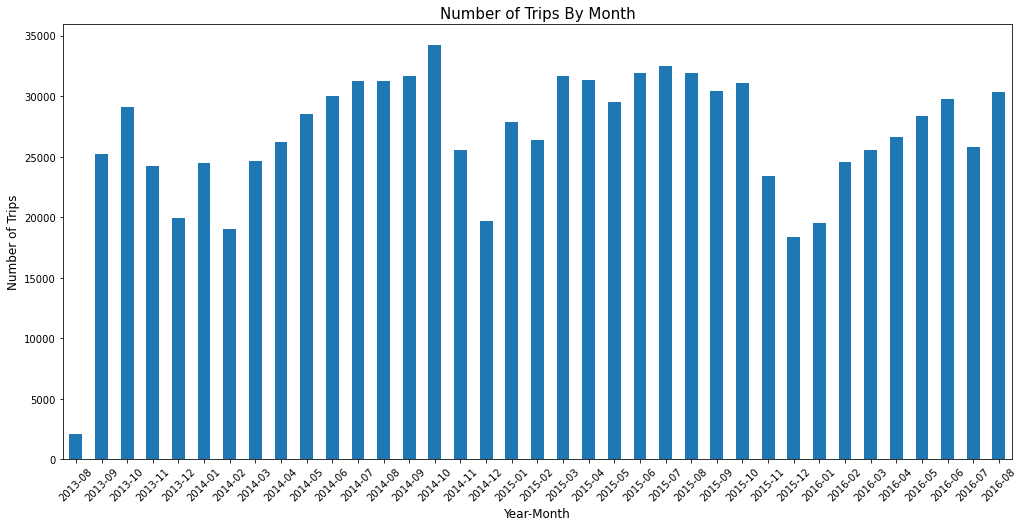

In [65]:
df6.groupby('Date').agg({'NumTrips':sum}).plot(kind='bar', figsize=(17,8))
plt.title('Number of Trips By Month', fontdict={'fontsize':15})
plt.xlabel('Year-Month', fontdict={'fontsize':12})
plt.xticks(rotation=45)
plt.ylabel('Number of Trips', fontdict={'fontsize':12})
plt.legend('',frameon=False)
pass


We can see that the number of trips per month follows a cyclical pattern for the duration of the dataset. We see higher levels of ridership during the months from February to October and lower levels during the winter months.

Let's break down this monthly trip level histogram into the subscriber types.

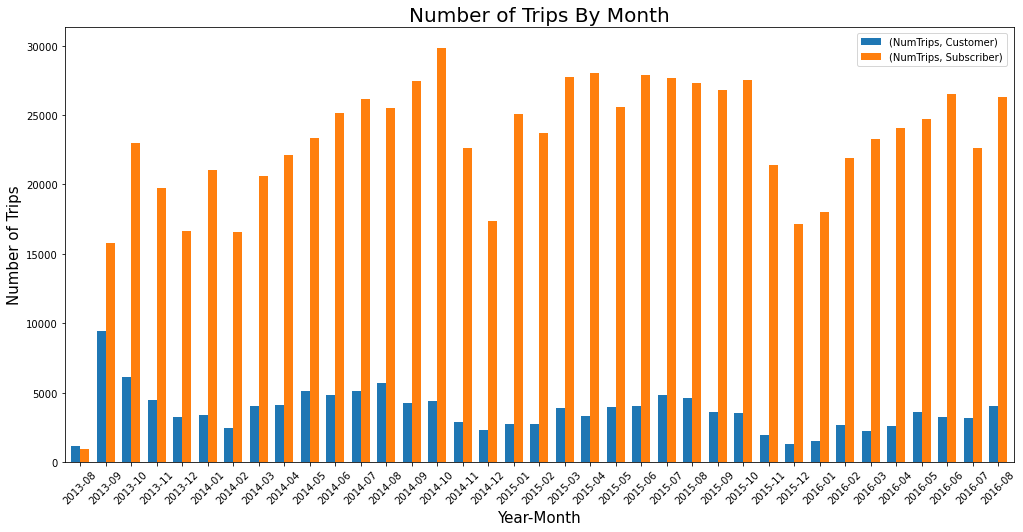

In [67]:
df6.groupby(['Date','subscriber_type']).agg({'NumTrips':sum}).unstack().plot(kind='bar', figsize=(17,8), width=0.7)

plt.title('Number of Trips By Month',fontdict={'fontsize':20})
plt.xlabel('Year-Month',fontdict={'fontsize':15})
plt.xticks(rotation=45)
plt.ylabel('Number of Trips',fontdict={'fontsize':15})
plt.legend(loc=(0.835,0.91))
pass

Both subscribers and customers follow the same cyclical pattern of higher levels of ridership during warmer months and lower levels during winter months. In order to encourage more people to ride during the winter months, Bay Wheels can look into promotional or discounted pricing for rides from November to January. Lower priced rides during the colder seasons would incentivize people to use Bay Wheel's bikesharing services. Furthermore, the winter months are also the holiday season. If Bay Wheels can partner with local businesses on special holiday promotions exclusive to bike riders, we can see a boost of customers and tourists bikesharing during the holidays. Another possibility is promoting bikesharing between Christmas market locations.

## __Conclusion__

Here is a recap of the analyses made in this report.

- The top 5 most popular commuter trips are located near other hubs of transportation. <br>Thus, bikesharing is only a component of people's everyday commute.
    - Bay Wheels can look into partnering with other transportation services for competitively priced commuting benefits and packages
- Bay Wheels should look into expanding dock and bike availability or bike reallocation services for certain stations during peak hours.
  <br> Stations include:
    * San Francisco Caltrain (Townsend at 4th)
    * Embarcadero at Vallejo
    * Commercial at Montgomery
    * Broadway St at Battery St
    * Harry Bridges Plaza (Ferry Building)   
- Customer trips have long trip durations that exceed the 30-minute limit stated by Bay Wheels' policies.
    - Improve the mobile application so that customers are better informed of this policy
    - Make it easier for customers to plan routes so that they can find available docking stations nearby and discourage surcharges    
- The most common route that customers take is from Harry Bridges Plaza to Embarcadero at Sansome.
    - Many of the stations that customers frequent are located along the waters by The Embarcadero
    - Bay Wheels should look into expanding bike station access along this avenue into Fisherman's Wharf to encourage riders to visit
    - Bay Wheels can partner with local vendors in new areas of service to promote ridership at these locations   
- Monthly ridership levels follow a cyclical pattern with higher levels during the periods from February to October.
    - Bay Wheels can look into promotional pricing during the winter months to encourage ridership
    - The company can also consider partnering with businesses on festive holiday deals exclusive to bike riders in order to boost tourism